# Two Harmonic
This looks at how much information can be extracted about the seasonal cycle, restricting ourselves to a two harmonics.

In [25]:
import copy
import sys
import os

from scipy.interpolate import CubicSpline

# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat, get_density, virtual_temp, saturation_vapor_pressure
from isca_tools.utils.constants import kappa, L_v, c_p, c_p_water, rho_water, Stefan_Boltzmann, R, R_v
from isca_tools.utils import area_weighting, annual_mean, annual_time_slice, anom_from_annual_mean, print_ds_var_list, numerical
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.adiabat_theory import get_temp_adiabat, get_temp_adiabat_surf
from isca_tools.convection.simple_betts_miller import lcl_temp, ref_temp_above_lcl, get_temp_ref
from isca_tools.convection import dry_profile_pressure, moist_profile, potential_temp
import isca_tools.utils.fourier as fourier
from isca_tools.utils.radiation import get_heat_capacity
from isca_tools.plot import colored_line
from isca_tools.thesis.surface_energy_budget import get_temp_fourier_analytic, get_temp_fourier_numerical, get_temp_extrema_analytic,\
    get_temp_extrema_numerical
from isca_tools.plot import label_subplots
from isca_tools.utils.calculus import grad_y
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from scipy.interpolate import CubicSpline
from tqdm.notebook import tqdm
from scipy import optimize, ndimage
import warnings
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
plt.rcParams['lines.linewidth'] = 0.8

In [2]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'height', 't_surf', 'swdn_sfc', 'lwup_sfc', 'lwdn_sfc', 
            'flux_lhe', 'flux_t', 'drag_q', 'q_surf', 'rho', 'p_atm', 'ps', 'q_surf', 'ucomp', 'vcomp', 'w_atm']
# Load dataset

# # DEFAULT experiment
# exp_dir = 'tau_sweep/aquaplanet/'
# exp_name = [f"k={str(tau_lw[i]).replace('.','_')}" for i in range(n_exp)]

# # Experiment with no-WISHE and no convection
# exp_dir = 'aquaplanet/no_wishe/'
# exp_name = [f"k={str(tau_lw[i]).replace('.','_')}_no_conv" for i in range(n_exp)]

# exp_dir = 'aquaplanet/no_wishe/'
# exp_name = ["k=1"]

exp_dir = 'aquaplanet/latent_heat_temp_only/'
exp_name = ['evap=0_1']
# exp_dir = 'aquaplanet/latent_heat_temp_only/depth=20/'
# exp_name = ['base']


# Get low level sigma level
namelist = isca_tools.load_namelist(exp_dir+exp_name[0])
p_surface_approx = namelist['spectral_dynamics_nml']['reference_sea_level_press']/100
sigma_levels_half = np.asarray(namelist['vert_coordinate_nml']['bk'])
sigma_levels_full = np.convolve(sigma_levels_half, np.ones(2)/2, 'valid')
sigma_near_surf = sigma_levels_full[-1]

n_exp = len(exp_name)
lat_range = slice(30, 90)               # only consider NH and outside deep tropics, and ignore high latitudes as need 2nd harmonic there
use_time_start = 360*2
ds_base = []
for i in tqdm(range(n_exp)):
    ds_use = isca_tools.load_dataset(exp_dir + exp_name[i])
    try:
        ds_use = ds_use[var_keep]
    except KeyError:
        remove_keys = []
        for key in var_keep:
            if key not in ds_use:
                print(f'Removing {key} from var_keep')
                remove_keys += [key]
        for key in remove_keys:
            var_keep.remove(key)
        ds_use = ds_use[var_keep]
    ds_use = ds_use.sel(time=slice(use_time_start, np.inf)).sel(lat=lat_range)
    ds_use = ds_use.sel(pfull=np.inf, method='nearest')      # only keep lowest level
    # Compute variables required for flux breakdown
    ds_use['emission_factor'] = ds_use.lwdn_sfc/(Stefan_Boltzmann*ds_use.temp**4)
    ds_use['temp_diseqb'] = ds_use.t_surf - ds_use.temp
    ds_use['rh'] = ds_use.sphum / sphum_sat(ds_use.temp, ds_use.ps*sigma_near_surf)
    ds_use['lw_net'] = ds_use.lwup_sfc - ds_use.lwdn_sfc
    ds_base += [ds_use.load()]      # only keep after spin up
mixed_layer_depth = [isca_tools.load_namelist(exp_dir+exp_name[i])['mixed_layer_nml']['depth'] for i in range(n_exp)]

is_wishe=True
try:
    w_atm_const = isca_tools.load_namelist(exp_dir+exp_name[0])['surface_flux_nml']['w_atm_const']
    if w_atm_const > 0:
        is_wishe=False
        for i in range(n_exp):
            # Set wind to the constant value if it is set in namelist
            ds_base[i]['w_atm'] = ds_base[i]['w_atm']*0+w_atm_const
except KeyError:
    w_atm_const = np.nan

try: 
    rh_flux_q = isca_tools.load_namelist(exp_dir+exp_name[0])['surface_flux_nml']['rh_flux_q']
except KeyError:
    rh_flux_q = 0
try:
    evap_prefactor = isca_tools.load_namelist(exp_dir+exp_name[0])['surface_flux_nml']['land_evap_prefactor']
except KeyError:
    evap_prefactor = 1

  0%|          | 0/1 [00:00<?, ?it/s]

Removing height from var_keep


In [3]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
im_sz = 1.4     # larger makes images larger, keeping ar the same
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

In [4]:
def get_annual_zonal_mean(ds):
    ds_av = annual_mean(ds).mean(dim='lon')
    ds_av = ds_av.assign_coords(time=(ds_av.time - ds_av.time.min()).astype(int))
    return ds_av

In [5]:
ds = get_annual_zonal_mean(ds_base[0])
p_surface = float(ds.pfull)*100
if isinstance(w_atm_const, (int, float)):
    if w_atm_const == 0 or w_atm_const == np.nan:
        w_atm_const = ds.w_atm.mean(dim='time')

In [6]:
# Make every thing dependent on surface temperature (NOT NEAR-SURFACE) as equation easier to solve
# Link to near-surface with T_{s-a} term in latent flux etc
n_lat = ds.lat.size
n_time = ds.time.size
t_surf = ds.t_surf.to_numpy().transpose()
t_surf_anom = t_surf - np.mean(t_surf, axis=1)[:, np.newaxis]

## How many harmonics required?
Here we look fit a fourier expansion of a given number of harmonics directly to the temperature and shortwave radiation. It seems that there is a large reduction in error as we go from 1 to 2 harmonics, but not much more is gained by including more than 2 harmonics.

The surface energy budget is 
$$
C\frac{\partial T}{\partial t} = SW^{\downarrow} - (LW^{\uparrow} - LW^{\downarrow}) - LH^{\uparrow} - SH^{\uparrow}
= SW^{\downarrow} - \Gamma^{\downarrow}
$$

If we can approximate $\Gamma^{\downarrow} \approx \lambda_0 + \lambda T'(t)$ then an analytic solution for temperature anomaly $T'(t)$ is possible. Given this linear approximation, we look at the effect of increasing the number of harmonics. 

It seems that at all latitudes, there is not much difference between the 2 and 5 harmonic direct fit, so it makes sense to only go up to 2 harmonics.

For all latitudes, there seems to be a big difference between the linear fit and the direct fit; thus it makes sense to see if we can go beyond the linear fit to $\Gamma$.

In [7]:
sw_amp_coefs = {key: np.zeros((n_lat, 1+int(key.replace('_harmonic', '')))) for key in ['1_harmonic', '2_harmonic', '5_harmonic']}
sw_fourier_fit = {key: np.zeros((n_lat, n_time)) for key in ['1_harmonic', '2_harmonic', '5_harmonic']}
temp_anom_fourier_fit = {key: np.zeros((n_lat, n_time)) for key in ['1_harmonic', '2_harmonic', '5_harmonic']}
for key in sw_amp_coefs:
    for i in range(n_lat):
        sw_amp_coefs[key][i] = fourier.get_fourier_fit(ds.time, ds.swdn_sfc[:, i], int(key.replace('_harmonic', '')))[1]
        # Fit SW fourier with no phase
        sw_fourier_fit[key][i] = fourier.fourier_series(ds.time, sw_amp_coefs[key][i], np.zeros(int(key.replace('_harmonic', ''))))
        temp_anom_fourier_fit[key][i] = fourier.get_fourier_fit(ds.time, t_surf_anom[i], int(key.replace('_harmonic', '')))[0]
    temp_anom_fourier_fit[key] = temp_anom_fourier_fit[key] - np.mean(temp_anom_fourier_fit[key], axis=1)[:, np.newaxis]
# Record phase of maxima / minima relative to extrema times of 1st harmonic of SW radiation 
time_extrema_sw = {'min': int(ds.time[0]), 'max': int(ds.time[int(ds.time.size/2)])}
smooth_ndays_temp_extrema = 20            # smoothing to temp annual mean to find date of hottest day

time_extrema_temp = {key: {'simulated': np.zeros(n_lat)} for key in ['min', 'max']}
amp_extrema_temp = {key: {'simulated': np.zeros(n_lat)} for key in ['min', 'max']}
for key in time_extrema_temp['min']:
    for i in range(n_lat):
        # No smoothing for '1_harmonic' as already fit smooth fourier solution
        time_extrema_temp['min'][key][i], time_extrema_temp['max'][key][i], amp_extrema_temp['min'][key][i], amp_extrema_temp['max'][key][i] = \
            get_temp_extrema_numerical(ds.time, t_surf_anom[i], smooth_ndays_temp_extrema)

In [8]:
# General plotting info
heat_capacity = get_heat_capacity(c_p_water, rho_water, mixed_layer_depth[0])
plot_lat_approx = 85
plot_lat_ind = np.argmin(np.abs(ds.lat-plot_lat_approx).to_numpy())
month_ticks = (np.arange(15,12*30+15,30), ['J','F','M','A','M','J','J','A','S','O','N','D'])
ax_lims_time = [ds.time[0]-1, ds.time[-1]+1]
ax_lims_lat = [np.floor(ds.lat[0]), np.ceil(ds.lat[-1])]
color_approx = {'simulated': 'k', 'direct fit': 'k', 'linear': default_colors[0], 'square': default_colors[1], '1_harmonic': 'k',
                'lw': default_colors[3], 'lh': default_colors[1], 'sh': default_colors[2], 'linear_phase': default_colors[0], 
                'square_phase': default_colors[1], '6_order_phase': default_colors[3], 'square_phase_fourier': default_colors[1],
                '6_order_phase_fourier': default_colors[3]}
color_extrema = {'max': default_colors[3], 'min': default_colors[0]}
linestyle_approx = {'simulated': '-', 'direct fit': ':', 'linear': ':', '1_harmonic': ':', 'linear_phase': '--', 'linear_phase_0': '-', 
                    'square': ':', 'square_phase': '--', '6_order_phase': '--', 'square_phase_fourier': '-', '6_order_phase_fourier': '-'}
color_harmonic = {'1_harmonic': 'k', '2_harmonic': default_colors[1], '5_harmonic': default_colors[3]}
color_var = {'sum': 'k', 'w_atm': default_colors[2], 'drag_q': default_colors[1], 'rh': default_colors[0], 'temp_diseqb': default_colors[4], 
             'ps': default_colors[5], 'emission_factor': default_colors[0], 't_surf': default_colors[3]}
var_unit_labels = {'w_atm': '[ms$^{-1}$]', 'drag_q': None, 'rh': None, 'temp_diseqb': '[K]', 'ps': '[Pa]', 'emission_factor': None}

# Define error func to use
error_func_dict = {'max': lambda x, x_approx, norm=False, axis=1: np.max(np.abs(x - x_approx), axis=axis) / 
                                                                 (0.01*x.max(axis=axis)-0.01*x.min(axis=axis) if norm else 1), 
                   'median': lambda x, x_approx, norm=False, axis=1: np.median(np.abs(x - x_approx), axis=axis) / 
                                                                 (0.01*x.max(axis=axis)-0.01*x.min(axis=axis) if norm else 1), 
                   'mean': lambda x, x_approx, norm=False, axis=1: np.mean(np.abs(x - x_approx), axis=axis) / 
                                                                  (0.01*x.max(axis=axis)-0.01*x.min(axis=axis) if norm else 1)}
error_func_use = 'mean'
error_func = error_func_dict[error_func_use.lower()]

# Whether to show plots with smoothing of simulated values done or not. Theoretical curves always shown without smoothing
# Will also smooth simulated var but not approximated var before calculating error
# Fitting is always done with no smoothing performed first.
plot_smooth = True
if plot_smooth:
    smooth_func = lambda x, ax=-1: scipy.ndimage.convolve1d(x, np.ones(smooth_ndays_temp_extrema)/smooth_ndays_temp_extrema, mode='wrap', axis=ax)
else:
    smooth_func = lambda x, ax=0: x

resample = False        # whether to resample data so evenly spaced in x before finding polynomial coefficents.

## Gamma Fitting Parameters
The surface energy budget is of the form $C\frac{d T}{dt} = F(t) - \Gamma(t)$ where:
$\Gamma(t) \approx \lambda_0 + \frac{1}{2}\lambda_{phase}(T'(t-\mathcal{T}/4) - T'(t+\mathcal{T}/4)) + \lambda T'(t) + \lambda_{sq}T'(t)^2 + \sum_{n=2}^N (\Lambda_{n, cos}\cos(2n\pi t/\mathcal{T}) + \Lambda_{n, sin}\sin(2n\pi t/\mathcal{T}))$

Below we find the parameters required to estimate $\Gamma$ by empirically fitting to each component of the surface flux separately.

In [9]:
key = 'simulated'
gamma_comp_params = {key: {} for key in ['lw', 'lh', 'sh']}
gamma_comp = {key: {} for key in ['lw', 'lh', 'sh']}
gamma_comp['lw'][key] = (ds.lwup_sfc-ds.lwdn_sfc).transpose().to_numpy()
gamma_comp['lh'][key] = (ds.flux_lhe).transpose().to_numpy()
gamma_comp['sh'][key] = (ds.flux_t).transpose().to_numpy()
n_approx_params = {'linear': 2, 'square': 3, '6_order': 7, 'square_phase_fourier': 6}
for key in ['linear', 'square', '6_order']:
    n_approx_params[key+'_phase'] = n_approx_params[key]+1

gamma = {'simulated': np.asarray(ds.lwup_sfc - ds.lwdn_sfc + ds.flux_lhe + ds.flux_t).transpose()}
gamma_params = {}

# arg indices are: cos_param, sin_param, phase_param, square_param, linear_param, lambda_0
arg_ind = {'linear': [4, 5], 'linear_phase': [2, 4, 5], 'square': [3, 4, 5], 'square_phase': [2, 3, 4, 5], 'square_phase_fourier': np.arange(6)}

for key in ['linear', 'linear_phase', 'square', 'square_phase', 'square_phase_fourier']:
    for key2 in gamma_comp:
        gamma_comp_params[key2][key] = np.zeros((n_lat, n_approx_params['square_phase_fourier']))
        gamma_comp[key2][key] = np.zeros((n_lat, n_time))
        for i in range(n_lat):
            if 'fourier' in key:
                # Last 4 parameters are the normal polyfit_phase parameters
                gamma_comp_params[key2][key][i, 2:], param_fourier_amp_use, param_fourier_phase_use = \
                    numerical.polyfit_phase(t_surf_anom[i], gamma_comp[key2]['simulated'][i],
                                            n_approx_params[key.replace('_phase_fourier', '')] - 1, resample=resample,
                                            fourier_harmonics=np.asarray([2]))
                # first 2 parameters are fourier coefficients - convert to cos and sin coefficients so can add together
                gamma_comp_params[key2][key][i, :2] = fourier.coef_conversion(param_fourier_amp_use[2], param_fourier_phase_use[1])
                gamma_comp[key2][key][i] = numerical.polyval_phase(gamma_comp_params[key2][key][i, 2:], t_surf_anom[i],
                                                                   coefs_fourier_amp=param_fourier_amp_use, coefs_fourier_phase=param_fourier_phase_use)
            elif 'phase' in key:
                gamma_comp_params[key2][key][i, arg_ind[key]] = numerical.polyfit_phase(t_surf_anom[i], gamma_comp[key2]['simulated'][i],
                                                                          n_approx_params[key.replace('_phase', '')] - 1, resample=resample)
                gamma_comp[key2][key][i] = numerical.polyval_phase(gamma_comp_params[key2][key][i, arg_ind[key]], t_surf_anom[i])
            else:
                gamma_comp_params[key2][key][i, arg_ind[key]] = numerical.polyfit_phase(t_surf_anom[i], gamma_comp[key2]['simulated'][i],
                                                                          n_approx_params[key]-1, include_phase=False, resample=resample)[1:]
                gamma_comp[key2][key][i] = np.polyval(gamma_comp_params[key2][key][i, arg_ind[key]], t_surf_anom[i])

    gamma_params[key] = np.zeros((n_lat, n_approx_params['square_phase_fourier']))
    gamma[key] = np.zeros((n_lat, n_time))
    gamma_params[key] = gamma_comp_params['lw'][key]+gamma_comp_params['lh'][key]+gamma_comp_params['sh'][key]
    for i in range(n_lat):
        param_fourier_amp_use, param_fourier_phase_use = fourier.coef_conversion(cos_coef=gamma_params[key][i, 0], sin_coef=gamma_params[key][i, 1])
        param_fourier_amp_use = np.asarray([0, 0, param_fourier_amp_use])
        param_fourier_phase_use = np.asarray([0, param_fourier_phase_use])
        gamma[key][i] = numerical.polyval_phase(gamma_params[key][i, 2:], t_surf_anom[i],
                                                coefs_fourier_amp=param_fourier_amp_use, coefs_fourier_phase=param_fourier_phase_use)

## Interpretation of Parameters in $\Gamma$ approximation
The different parameters in the approximation for $\Gamma$ can be interpreted in terms of an effective heat capacity and feedback parameter experienced by each harmonic
i.e. $\frac{C_eff}{C} \neq 1$ and $\frac{\lambda_{eff}}{\lambda} \neq 1$.

Below, we do a sanity check that this interpretation matches the analytic solution. Note the effective heat capacity and $\lambda$ seen by each harmonic is different.

In [10]:
def get_effective_heat_capacity_lambda_scale(heat_capacity, lambda_const, lambda_phase=0, lambda_sq=0, lambda_cos=0,
                                             lambda_sin=0, sw_amp1=None, sw_amp2=None, approx=False, n_days_year = 360, day_seconds=86400):
    # Get factors such that lambda_mod = lambda_scale * lambda and heat_capacity_mod = heat_capacity_scale * heat_capacity
    # Then with these modified factors, can use normal simple surface energy budget: C_mod * dT(t)/dt = F(t) - lambda_mod * T(t)
    f = 1/(n_days_year * day_seconds)
    if sw_amp1 is None:
        # If don't give insolation information, then return modification for parameters as seen by the 1st harmonic
        lambda_scale = 1
        heat_capacity_scale = 1 - lambda_phase / (2*np.pi*f*heat_capacity)
    else:
        # If have insolation information, return modification for parameters as seen by the 2nd harmonic
        x0 = 2*np.pi*f*heat_capacity / lambda_const
        sw_amp_eff = [sw_amp1, sw_amp2 - lambda_cos]

        sq_param = 0.5 * lambda_sq * sw_amp_eff[0]**2 / (lambda_const**2 * sw_amp_eff[1])/(1+x0**2)**2
        fourier_param = lambda_sin / sw_amp_eff[1]
        if approx:
            # Return linear taylor series solution
            lambda_scale = 1 + (3*x0**2+1)*sq_param + 2*x0*fourier_param
            heat_capacity_scale = 1 - x0**2 * sq_param - 0.5/x0 * fourier_param
        else:
            f_beta = 1 - (sq_param*(1+4*x0**2) + fourier_param*(2*x0+0.5/x0))/(1 + sq_param*(5*x0**2-1) + fourier_param*2*x0)
            lambda_scale = (1 + f_beta*4*x0**2) / (1 + sq_param*(x0**2-1)) / (1 + f_beta**2*4*x0**2)
            heat_capacity_scale = f_beta * lambda_scale
    return lambda_scale, heat_capacity_scale


def get_effective_lambda_interpretation(time, sw_amp1, sw_amp2, heat_capacity, lambda_const, lambda_phase=0, lambda_sq=0, lambda_cos=0, lambda_sin=0,
                                        approx=False, day_seconds=86400):
    f = 1/(time.size * day_seconds)
    sw_amp_eff = np.asarray([sw_amp1, sw_amp2 - lambda_cos])

    # Get effective parameters - allow different for each harmonic
    n_harmonics = 2
    lambda_mod = lambda_const * np.ones(n_harmonics)
    heat_capacity_mod = heat_capacity * np.ones(n_harmonics)

    # Phase - changes 1st harmonic only
    lambda_scale, heat_cap_scale = \
        get_effective_heat_capacity_lambda_scale(heat_capacity, lambda_const, lambda_phase, lambda_sq, lambda_cos, lambda_sin)
    lambda_mod[0] = lambda_mod[0] * lambda_scale
    heat_capacity_mod[0] = heat_capacity_mod[0] * heat_cap_scale
    # heat_capacity_mod[0] -= lambda_phase / (2*np.pi*f)

    lambda_scale, heat_cap_scale = \
        get_effective_heat_capacity_lambda_scale(heat_capacity, lambda_const, lambda_phase, lambda_sq, lambda_cos, lambda_sin,
                                                 sw_amp1, sw_amp2, approx)
    lambda_mod[1] = lambda_mod[1] * lambda_scale
    heat_capacity_mod[1] = heat_capacity_mod[1] * heat_cap_scale
    # x0 = 2*np.pi*f*heat_capacity / lambda_const
    # sq_param = 0.5 * lambda_sq * sw_amp_eff[0]**2 / (lambda_const**2 * sw_amp_eff[1])/(1+x0**2)**2
    # # sq_param = 0.5 * lambda_sq * sw_amp1**2 / (lambda_const**2 * sw_amp2)/(1+x0**2)**2
    # fourier_param = lambda_sin / sw_amp_eff[1]
    # # f_beta = (1 - fourier_param/(2*x0) - sq_param) / (1 + 2*x0*fourier_param + 4*x0**2*sq_param)
    # f_beta = 1 - (sq_param*(1+4*x0**2) + fourier_param*(2*x0-0.5/x0))/(1 + sq_param*(5*x0**2-1) + fourier_param*2*x0)
    # lambda_mod[1] = lambda_const * (1 + f_beta*4*x0**2) / (1 + sq_param*(x0**2-1)) / (1 + f_beta**2*4*x0**2)
    # heat_capacity_mod[1] = heat_capacity * f_beta * (1 + f_beta*4*x0**2) / (1 + sq_param*(x0**2-1)) / (1 + f_beta**2*4*x0**2)

    x = 2*np.pi*f*heat_capacity_mod * np.arange(1, n_harmonics+1)/lambda_mod
    phase_coef = np.arctan(x)
    amp_coef = sw_amp_eff / lambda_mod / np.sqrt(1 + x ** 2)
    harmonic1 = fourier.fourier_series(time, [0, amp_coef[0], 0], [phase_coef[0], 0])
    harmonic2 = fourier.fourier_series(time, [0, 0, amp_coef[1]], [0, phase_coef[1]])
    return harmonic1, harmonic2, harmonic1 + harmonic2

# i=5
# key='linear_fourier'
# var_use = get_effective_lambda_interpretation(ds.time.to_numpy(), sw_amp_coefs['2_harmonic'][i, 1],
#                                               sw_amp_coefs['2_harmonic'][i, 2], heat_capacity,
#                                               gamma_params[key][i, 4], lambda_phase=gamma_params[key][i, 2],
#                                               lambda_sq=gamma_params[key][i, 3],
#                                               lambda_cos=gamma_params[key][i, 0],
#                                               lambda_sin=gamma_params[key][i, 1], approx=show_approx)

In [11]:
# Get approximate temperature for each level in hierarchy of gamma approximation
temp_anom_analytic = {key: np.zeros((n_lat, n_time)) for key in ['linear', 'linear_phase', 'square', 'square_phase',
                                                                 'square_phase_fourier', 'linear_fourier', 'linear_phase_fourier',
                                                                 'square_fourier']}
gamma_params['linear_fourier'] = gamma_params['square_phase_fourier'] * [1, 1, 0, 0, 1, 1]
gamma_params['linear_phase_fourier'] = gamma_params['square_phase_fourier'] * [1, 1, 1, 0, 1, 1]
gamma_params['square_fourier'] = gamma_params['square_phase_fourier'] * [1, 1, 0, 1, 1, 1]
for key in temp_anom_analytic:
    for i in range(n_lat):
        temp_anom_analytic[key][i] = get_temp_fourier_analytic(ds.time.to_numpy(), ds.swdn_sfc.isel(lat=i).to_numpy(), heat_capacity,
                                                               gamma_params[key][i, 4], gamma_params[key][i, 2], gamma_params[key][i, 3],
                                                               gamma_params[key][i, 0], gamma_params[key][i, 1], n_harmonics_sw=2)[0]

In [12]:
# Sanity check
key = 'square_fourier'        # expect combination of square and phase to give slight error due to neglecting combined phase-square effects
                                    # all else should be 0
show_approx = False                 # Check linear taylor series version
var = []
var2 = []
for i in range(n_lat):
    var_use = get_effective_lambda_interpretation(ds.time.to_numpy(), sw_amp_coefs['2_harmonic'][i, 1],
                                                  sw_amp_coefs['2_harmonic'][i, 2], heat_capacity,
                                                  gamma_params[key][i, 4], lambda_phase=gamma_params[key][i, 2],
                                                  lambda_sq=gamma_params[key][i, 3],
                                                  lambda_cos=gamma_params[key][i, 0],
                                                  lambda_sin=gamma_params[key][i, 1], approx=show_approx)
    # Should be zero
    var += [np.round(np.abs(temp_anom_analytic[key][i]-var_use[-1]).max(), 6)]
print(var)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


## Expansion about maxima of 1st Harmonic
We want a simple equation which indicates how the 2nd harmonic shifts the extrema from that of the first harmonic. To do this, we expand about the time of th 1st maxima i.e. $t=t_{max1} + \Delta$, where $t_{max1} = \frac{\arctan(\frac{2\pi fC}{\lambda})}{2\pi f}$ is the maxima of the 1st harmonic for the simple linear surface energy budget of the form $C\frac{dT}{dt} = F(t) - \lambda T(t)$.

In shifting the time coordinate, we can write the 2 harmonic solution of temperature in the form:
$T(\Delta) = a_1 \cos(2\pi ft) + b_1 \sin(2\pi ft) + a_2 \cos(4\pi ft) + b_2 \sin(4\pi ft)$

where the $a_i$ and $b_i$ parameters include the $\lambda_{eff}$ and $C_{eff}$ modifications for the $i^{th}$ harmonic.

Below we do a sanity check that this coordinate shift is correct.

In [106]:
def get_shift_t_analytic_temp(time, sw_amp1, sw_amp2, heat_capacity, lambda_const, lambda_phase=0, lambda_sq=0, lambda_cos=0, lambda_sin=0,
                              harmonic_extrema_ind=1, day_seconds=86400, approx=False):
    # Returns solution of form a_1cos(2 pi f t') + b_1sin(2 pi f t') + a_2cos(4 pi f t') + b_2sin(4 pi f t')
    # where t' = t - t_{max1} where t_{max1} is time of 1st harmonic extrema in case where lambda_phase=0, lambda_sq=0, lambda_cos=0, lambda_sin=0.
    # When considering the 2nd harmonic, a_1 and b_1 get multiplied by -1. This is the only change.
    f = 1/(time.size * day_seconds)
    sw_amp_eff = np.asarray([sw_amp1, sw_amp2 - lambda_cos])

    # Get effective parameters - allow different for each harmonic
    n_harmonics = 2
    lambda_scale = np.ones(n_harmonics)      # lambda_mod = eta * lambda
    heat_cap_scale = np.ones(n_harmonics)   # heat_capacity_mod = heat_cap_scale * heat_capacity

    # 1st harmonic
    lambda_scale[0], heat_cap_scale[0] = \
        get_effective_heat_capacity_lambda_scale(heat_capacity, lambda_const, lambda_phase, lambda_sq, lambda_cos, lambda_sin, approx=approx)

    # 2nd harmonic
    lambda_scale[1], heat_cap_scale[1] = \
        get_effective_heat_capacity_lambda_scale(heat_capacity, lambda_const, lambda_phase, lambda_sq, lambda_cos, lambda_sin,
                                                 sw_amp1, sw_amp2, approx=approx)
    mu = heat_cap_scale / lambda_scale       # mu = (heat_capacity_mod / lambda_mod) / (heat_capacity/lambda) = heat_cap_scale / eta

    x = 2*np.pi*f*heat_capacity/lambda_const
    a_1 = sw_amp_eff[0]/lambda_const/lambda_scale[0] * (1 + mu[0]*x**2)/np.sqrt((1+x**2)*(1+mu[0]**2*x**2)**2)
    b_1 = -sw_amp_eff[0]/lambda_const/lambda_scale[0] * x * (1-mu[0])/np.sqrt((1+x**2)*(1+mu[0]**2*x**2)**2)
    a_2 = sw_amp_eff[0]/lambda_const/lambda_scale[1] * (sw_amp_eff[1]/sw_amp_eff[0]) * (1-x**2+4*mu[1]*x**2)/((1+x**2)*(1+4*mu[1]**2*x**2))
    b_2 = sw_amp_eff[0]/lambda_const/lambda_scale[1] * (sw_amp_eff[1]/sw_amp_eff[0]) * (2*mu[1]*x*(1-x**2) - 2*x)/((1+x**2)*(1+4*mu[1]**2*x**2))
    time_shift = time * day_seconds - np.arctan(x)/(2*np.pi*f)      # in seconds
    if harmonic_extrema_ind == 2:
        a_1 = -a_1
        b_1 = -b_1
        time_shift = time_shift - 1/(2*f)
    temp_analytic = a_1 * np.cos(2*np.pi*f*time_shift) + b_1 * np.sin(2*np.pi*f * time_shift) + a_2 * np.cos(4*np.pi*f * time_shift) + b_2 * np.sin(4*np.pi*f * time_shift)
    return temp_analytic, a_1, b_1, a_2, b_2, lambda_scale, heat_cap_scale

In [107]:
# Sanity check
key = 'square_phase_fourier'        # expect combination of square and phase to give slight error due to neglecting combined phase-square effects
                                    # all else should be 0
var = []
for i in range(n_lat):
    var_use = get_effective_lambda_interpretation(ds.time.to_numpy(), sw_amp_coefs['2_harmonic'][i, 1],
                                                  sw_amp_coefs['2_harmonic'][i, 2], heat_capacity,
                                                  gamma_params[key][i, 4], lambda_phase=gamma_params[key][i, 2],
                                                  lambda_sq=gamma_params[key][i, 3],
                                                  lambda_cos=gamma_params[key][i, 0],
                                                  lambda_sin=gamma_params[key][i, 1])
    # Check that shifting around maxima of 1st harmonic correct
    var_use2 = get_shift_t_analytic_temp(ds.time.to_numpy(), sw_amp_coefs['2_harmonic'][i, 1],
                                         sw_amp_coefs['2_harmonic'][i, 2], heat_capacity,
                                         gamma_params[key][i, 4], lambda_phase=gamma_params[key][i, 2],
                                         lambda_sq=gamma_params[key][i, 3],
                                         lambda_cos=gamma_params[key][i, 0],
                                         lambda_sin=gamma_params[key][i, 1], harmonic_extrema_ind=1)
    # Should be zero
    var += [np.round(np.abs(var_use2[0]-var_use[-1]).max(), 6)]
print(var)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


### Extrema Time
Extrema occur where $\frac{\partial T}{\partial \Delta} = 0$, writing $y=\cos(2\pi f\Delta)$, this is where:

$f(y) = -a_1y + b\sqrt{1-y^2} - 4a_2 y \sqrt{1-y^2} + 2b_2 (1-2y^2)=0$

If we assume $y$ is small (i.e. extrema occur near where expect for 1st harmonic), then we can expand about $y=0$ to give:

$f(y) \approx b_1 + 2b_2 - (a_1 + 4a_2)y - \frac{1}{2}(b_1 + 8b_2) y^2$

Solving $f(y)=0$ in this simplified form gives:

$y = \frac{-1 + \sqrt{1+2\gamma y_0^2}}{\gamma y_0}$

where $y_0 = \frac{b_1+2b_2}{a_1+4a_2}$ and $\gamma = 1 + \frac{6b_2}{b_1 + 2b_2}$, and $y_0$ is the solution if we neglect the $y^2$ term in $f(y)$ taylor expansion.

Below we look at how good an approximation this is for the extrema of $y$.

In [108]:
def get_extrema_time(time, sw_amp1, sw_amp2, heat_capacity, lambda_const, lambda_phase=0, lambda_sq=0, lambda_cos=0, lambda_sin=0,
                     harmonic_extrema_ind=1, day_seconds=86400, approx=False):
    # Returns function T(y) and dT_dt such that dT_dt(y)=0 gives values of extrema of y where y=sin(2pif\Delta) and time=t_extrema_1 + \Delta,
    # where t_extrema_1 is the time of the first harmonic extrema
    # T(y) is temperature evaluated at y=sin(2pif\Delta)
    # Also returns y corresponding to extrema and T evaluated at this y.
    a_1, b_1, a_2, b_2, lambda_scale, heat_cap_scale = get_shift_t_analytic_temp(time, sw_amp1, sw_amp2, heat_capacity, lambda_const,
                                                            lambda_phase, lambda_sq, lambda_cos, lambda_sin, harmonic_extrema_ind, day_seconds)[1:]
    # mu = heat_cap_scale / lambda_scale
    amplitude0 = get_shift_t_analytic_temp(time, sw_amp1, sw_amp2, heat_capacity, lambda_const,
                                           0, 0, 0, 0, harmonic_extrema_ind, day_seconds)[1]        # a_1 with all parameters set to 0
    y_0 = (b_1 + 2*b_2) / (a_1 + 4*a_2)
    freq = 1/(time.size)       # frequency in day^{-1} units
    if not approx:
        T_func = lambda y: a_1*np.sqrt(1-y**2) + b_1*y + a_2*(1-2*y**2) + 2*b_2*y*np.sqrt(1-y**2)
        dT_dt_func = lambda y: (-a_1*y + b_1*np.sqrt(1-y**2) - 4*a_2*y*np.sqrt(1-y**2) + 2*b_2*(1-2*y**2)) * 2 * np.pi * freq
        y_extrema = scipy.optimize.least_squares(dT_dt_func, 0, bounds=(-1, 1))['x'][0]
    elif approx == 'linear':
        T_func = lambda y: a_1 + a_2 + (b_1 + 2*b_2)*y
        dT_dt_func = lambda y: (b_1 + 2*b_2 - (a_1+4*a_2)*y) * 2 * np.pi * freq
        y_extrema = y_0
        # f = 1/(time.size * day_seconds)
        # sw_amp_eff = np.asarray([sw_amp1, sw_amp2 - lambda_cos])
        # x = 2*np.pi*f*heat_capacity/lambda_const
        # mu1_coef = x/(1+x**2)
        # sw_linear_coef = -4*x**3/ (1+x**2)**0.5 / (1+4*x**2)
        # mu1_nl_coef = 4*x*(-x**4+3*x**2+1) / (1+x**2)**1.5 / (1+4*x**2)
        # eta2_coef = -sw_linear_coef
        # mu2_coef = 4*x*(4*x**4+3*x**2+1) / (1+x**2)**0.5 / (1+4*x**2)**2
        # y_extrema = mu1_coef * (mu[0]-1) + sw_amp_eff[1]/sw_amp_eff[0] * (sw_linear_coef + mu1_nl_coef*(mu[0]-1) + eta2_coef*(eta[1]-1) +
        #                                                                   mu2_coef*(mu[1]-1))
    elif approx == 'square':
        T_func = lambda y: a_1 + a_2 + (b_1 + 2*b_2)*y - 0.5*(a_1 + 4*a_2)*y**2
        dT_dt_func = lambda y: (b_1 + 2*b_2 - (a_1+4*a_2)*y - 0.5*(b_1+8*b_2)*y**2) * 2 * np.pi * freq
        mod_factor = 1 + 6*b_2/(b_1 + 2*b_2)
        y_extrema = (-1 + np.sqrt(1+2*mod_factor*y_0**2)) / (mod_factor*y_0)
        # y_extrema = y_0 - 0.5*mod_factor*y_0**3#   +  (3/8)*mod_factor**2*y_0**5

    else:
        raise ValueError('approx must be either linear or square or False')
    return T_func, dT_dt_func, y_extrema, T_func(y_extrema)/amplitude0
# key = 'linear_fourier'
# plot_lat_ind=5
# get_extrema_time(ds.time.to_numpy(), sw_amp_coefs['2_harmonic'][plot_lat_ind, 1],
#                                              sw_amp_coefs['2_harmonic'][plot_lat_ind, 2], heat_capacity,
#                                              gamma_params[key][plot_lat_ind, 4], lambda_phase=gamma_params[key][plot_lat_ind, 2],
#                                              lambda_sq=gamma_params[key][plot_lat_ind, 3],
#                                              lambda_cos=gamma_params[key][plot_lat_ind, 0],
#                                              lambda_sin=gamma_params[key][plot_lat_ind, 1], approx='linear')[:2]

In [109]:
def get_y(time, heat_capacity, lambda_const, extrema_ind=1, day_seconds=86400, n_days_year=360):
    # Returns y=sin(2\pi f\Delta) where \Delta=t_extrema - t_extrema_1
    # I.e. the time and amplitude of extrema relative to first harmonic
    f = 1/(n_days_year * day_seconds)
    x = 2*np.pi*f*heat_capacity/lambda_const
    time_harmonic1 = np.arctan(x)/(2*np.pi*f)
    if extrema_ind == 2:
        time_harmonic1 = time_harmonic1 + 1/(2*f)
    time_shift = time * day_seconds - time_harmonic1
    y = np.sin(2*np.pi*f*time_shift)
    # temp_spline = CubicSpline(np.append(time, time[-1]+1), np.append(temp, temp[0]), bc_type='periodic')
    return y

def get_phase_amp_relative_harmonic1(time_extrema, temp_extrema, sw_amp1, heat_capacity, lambda_const,
                                     extrema_ind=1, day_seconds=86400, n_days_year=360):
    # Returns y=sin(2\pi f\Delta) where \Delta=t_extrema - t_extrema_1 and A=T_extrema/T_extrema_1
    # I.e. the time and amplitude of extrema relative to first harmonic
    f = 1/(n_days_year * day_seconds)
    x = 2*np.pi*f*heat_capacity/lambda_const
    y = get_y(time_extrema, heat_capacity, lambda_const, extrema_ind, day_seconds, n_days_year)
    amp_harmonic1 = np.abs(sw_amp1/lambda_const/np.sqrt(1+x**2))
    return y, temp_extrema/amp_harmonic1

In [110]:
y_extrema = {key: {key2: np.zeros((n_lat, 2)) for key2 in ['simulated', 'theory_full', 'linear', 'square']} for key in gamma_params}
amp_scale_extrema = {key: {key2: np.zeros((n_lat, 2)) for key2 in ['simulated', 'theory_full', 'linear', 'square']} for key in gamma_params}
for key in y_extrema:
    for key2 in y_extrema['linear']:
        for i in range(n_lat):
            for j in range(2):
                if key2 == 'simulated':
                    y_extrema[key][key2][i, j], amp_scale_extrema[key][key2][i, j] = \
                        get_phase_amp_relative_harmonic1(time_extrema_temp['min' if j==0 else 'max'][key2][i],
                                                         amp_extrema_temp['min' if j==0 else 'max'][key2][i],
                                                         sw_amp_coefs['2_harmonic'][i, 1], heat_capacity, gamma_params[key][i, 4], j+1)
                else:
                    y_extrema[key][key2][i, j], amp_scale_extrema[key][key2][i, j] = \
                        get_extrema_time(ds.time.to_numpy(), sw_amp_coefs['2_harmonic'][i, 1],
                                         sw_amp_coefs['2_harmonic'][i, 2], heat_capacity, gamma_params[key][i, 4], lambda_phase=gamma_params[key][i, 2],
                                         lambda_sq=gamma_params[key][i, 3], lambda_cos=gamma_params[key][i, 0], lambda_sin=gamma_params[key][i, 1],
                                         approx=False if key2=='theory_full' else key2, harmonic_extrema_ind=j+1)[2:]

In [111]:
def sort_arrays_by_first(arr1, arr2):
    # Combine arr1 and arr2 into tuples
    combined = list(zip(arr1, arr2))

    # Sort the combined list based on arr1 (the first element of each tuple)
    sorted_combined = sorted(combined, key=lambda x: x[0])

    # Extract sorted arrays from sorted_combined
    sorted_arr1 = [item[0] for item in sorted_combined]
    sorted_arr2 = [item[1] for item in sorted_combined]

    return sorted_arr1, sorted_arr2

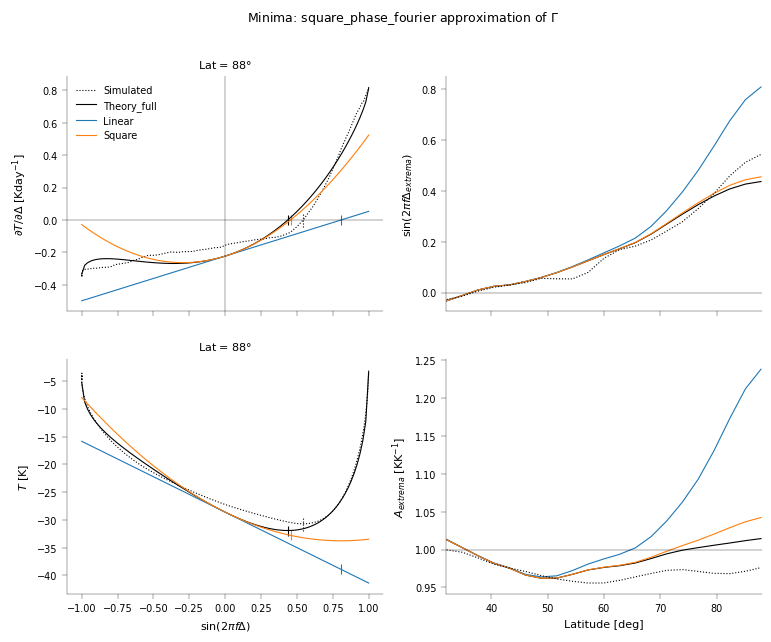

In [112]:
y_plot = np.linspace(-1, 1, 100)
key = 'square_phase_fourier'
plot_extrema_ind = 1
plot_extrema_label = ['Minima', 'Maxima']
var = get_shift_t_analytic_temp(ds.time.to_numpy(), sw_amp_coefs['2_harmonic'][plot_lat_ind, 1],
                                sw_amp_coefs['2_harmonic'][plot_lat_ind, 2], heat_capacity,
                                gamma_params[key][plot_lat_ind, 4],
                                0, 0, 0, 0, plot_extrema_ind)[1]        # a_1 with all parameters set to 0
color_use = {'theory_full': 'k', 'linear': default_colors[0], 'square': default_colors[1]}
label_use = {'theory_full': 'k', 'linear': default_colors[0], 'square': default_colors[1]}
fig, ax = plt.subplots(2, 2, figsize=(im_sz*2*width['one_col'], 2*im_sz*width['one_col']/ar), sharex='col')

# Plot simulated stuff
spline_temp = CubicSpline(np.append(ds.time, ds.time[-1]+1), # use smoothed temp as use smoothed temp to find simulated extrema in time_extrema_temp
                          np.append(smooth_func(t_surf_anom[plot_lat_ind]), smooth_func(t_surf_anom[plot_lat_ind])[0]), bc_type='periodic')
spline_y = get_y(ds.time.to_numpy(), heat_capacity, gamma_params[key][plot_lat_ind, 4], plot_extrema_ind)
if plot_extrema_ind == 2:
    use_ind = t_surf_anom[plot_lat_ind]>np.abs(var)/10
else:
    use_ind = t_surf_anom[plot_lat_ind]<-np.abs(var)/10
var2 = sort_arrays_by_first(spline_y[use_ind], spline_temp.derivative()(ds.time)[use_ind])
ax[0, 0].plot(var2[0], var2[1], color='k', linestyle=':', label='Simulated')
ax[0, 0].scatter(y_extrema[key]['simulated'][plot_lat_ind, plot_extrema_ind-1], 0, linestyle=':', color='k', marker='|', s=100)
var2 = sort_arrays_by_first(spline_y[use_ind], spline_temp(ds.time)[use_ind])
ax[1, 0].plot(var2[0], var2[1], color='k', linestyle=':')
ax[1, 0].scatter(y_extrema[key]['simulated'][plot_lat_ind, plot_extrema_ind-1],
                 amp_scale_extrema[key]['simulated'][plot_lat_ind, plot_extrema_ind - 1] * var, linestyle=':', color='k', marker='|', s=100)


for key2 in ['theory_full', 'linear', 'square']:
    func_use = get_extrema_time(ds.time.to_numpy(), sw_amp_coefs['2_harmonic'][plot_lat_ind, 1],
                                sw_amp_coefs['2_harmonic'][plot_lat_ind, 2], heat_capacity,
                                gamma_params[key][plot_lat_ind, 4], lambda_phase=gamma_params[key][plot_lat_ind, 2],
                                lambda_sq=gamma_params[key][plot_lat_ind, 3],
                                lambda_cos=gamma_params[key][plot_lat_ind, 0],
                                lambda_sin=gamma_params[key][plot_lat_ind, 1], approx=False if key2=='theory_full' else key2,
                                harmonic_extrema_ind=plot_extrema_ind)
    ax[0, 0].plot(y_plot, func_use[1](y_plot), color=color_use[key2], label=key2.capitalize())
    ax[0, 0].scatter(y_extrema[key][key2][plot_lat_ind, plot_extrema_ind-1], 0, color=color_use[key2], marker='|', s=50)
    ax[0, 1].plot(ds.lat, y_extrema[key][key2][:, plot_extrema_ind-1], color=color_use[key2],
               label=key2)
    ax[1, 0].plot(y_plot, func_use[0](y_plot), color=color_use[key2])
    ax[1, 0].scatter(y_extrema[key][key2][plot_lat_ind, plot_extrema_ind-1],
                     amp_scale_extrema[key][key2][plot_lat_ind, plot_extrema_ind - 1] * var,
                     color=color_use[key2], marker='|', s=50)
    ax[1, 1].plot(ds.lat, amp_scale_extrema[key][key2][:, plot_extrema_ind - 1], color=color_use[key2])

ax[0, 1].plot(ds.lat, y_extrema[key]['simulated'][:, plot_extrema_ind - 1], color='k', linestyle=':')
ax[1, 1].plot(ds.lat, amp_scale_extrema[key]['simulated'][:, plot_extrema_ind - 1], color='k', linestyle=':')

ax[0, 0].axhline(0, color='k', lw=ax_linewidth)
ax[0, 1].axhline(0, color='k', lw=ax_linewidth)
ax[1, 1].axhline(1, color='k', lw=ax_linewidth)
ax[0, 0].axvline(0, color='k', lw=ax_linewidth)
ax[0, 0].legend()
ax[0, 0].set_ylabel('$\partial T/\partial \Delta$ [Kday$^{-1}$]')
ax[1, 0].set_ylabel('$T$ [K]')
ax[1, 1].set_ylabel('$A_{extrema}$ [KK$^{-1}$]')
ax[1, 0].set_xlabel('$\sin(2\pi f \Delta)$')
ax[1, 1].set_xlim(ax_lims_lat)
ax[1, 1].set_xlabel('Latitude [deg]')
ax[0, 1].set_ylabel('$\sin(2\pi f \Delta_{extrema})$')
fig.suptitle(f'{plot_extrema_label[plot_extrema_ind-1]}: {key} approximation of $\Gamma$', fontsize=9, y=0.98)
ax[0, 0].set_title(f"Lat = ${ds.lat[plot_lat_ind]:.0f}\degree$")
ax[1, 0].set_title(f"Lat = ${ds.lat[plot_lat_ind]:.0f}\degree$")
plt.show()

## Parameter Influence on Extrema Date and Amplitude
Below we look at how the different parameters influence the extrema.

### Variation of parameters with latitude
Below we look at how each parameter varies with latitude. In particular, we see that $F_2/F_1$ changes sign around $45\degree$, causing the effective heat capacity and $\lambda$ scaling to deviate significantly from 1 around this latitude.

For the 1st harmonic, the effective heat capacity scaling is entirely set by $\lambda_{phase}$ - it is less than 1 when $\lambda_{phase}>0$ and more than 1 when $\lambda_{phase}<0$.

In [139]:
heat_capacity_scale = {key: np.ones((n_lat, 2)) for key in gamma_params}
lambda_scale = {key: np.ones((n_lat, 2)) for key in gamma_params}
for key in heat_capacity_scale:
    for i in range(n_lat):
        lambda_scale[key][i], heat_capacity_scale[key][i] = get_shift_t_analytic_temp(ds.time.to_numpy(), sw_amp_coefs['2_harmonic'][i, 1],
                                             sw_amp_coefs['2_harmonic'][i, 2], heat_capacity,
                                             gamma_params[key][i, 4], lambda_phase=gamma_params[key][i, 2],
                                             lambda_sq=gamma_params[key][i, 3],
                                             lambda_cos=gamma_params[key][i, 0],
                                             lambda_sin=gamma_params[key][i, 1], approx=False)[-2:]

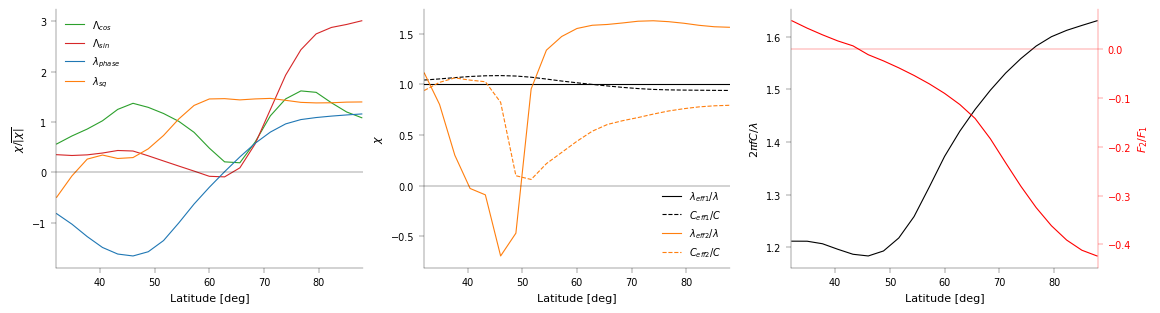

In [181]:
key = 'square_phase_fourier'
labels_param = ['$\Lambda_{cos}$', '$\Lambda_{sin}$', '$\lambda_{phase}$', '$\lambda_{sq}$', '$\lambda$', '$F_2/F_1$']
color_param = [default_colors[2], default_colors[3], default_colors[0], default_colors[1], default_colors[4], default_colors[5]]

fig, ax = plt.subplots(1, 3, figsize=(3*im_sz*width['one_col'], im_sz*width['one_col']/ar), sharex=True)
for i in range(n_approx_params[key]-2):
    ax[0].plot(ds.lat, (gamma_params[key]/np.mean(np.abs(gamma_params[key]), axis=0))[:, i], label=labels_param[i], color=color_param[i])
for i in range(2):
    ax[1].plot(ds.lat, lambda_scale[key][:, i], color=color_harmonic[f'{i+1}_harmonic'], label=f'$\lambda_{"{eff" + str(i+1)+"}"}/\lambda$')
    ax[1].plot(ds.lat, heat_capacity_scale[key][:, i], linestyle='--', color=color_harmonic[f'{i+1}_harmonic'],
               label=f'$C_{"{eff" + str(i+1)+"}"}/C$')

ax[2].plot(ds.lat, 2*np.pi/(360*86400)*heat_capacity/gamma_params[key][:, 4], color='k')
ax[2].set_ylabel('$2\pi fC/\lambda$')
ax2 = ax[2].twinx()
# Plot the second line on ax2
ax2.plot(ds.lat, sw_amp_coefs['2_harmonic'][:, 2]/sw_amp_coefs['2_harmonic'][:, 1], color='r')
ax2.set_ylabel('$F_2/F_1$', color='r')
ax2.tick_params(axis='y', colors='r')  # Change tick color to red
# Customize the spine color of ax2
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['right'].set_visible(True)
ax2.spines['right'].set_color('r')

ax[0].legend()
ax[1].legend()
ax[0].axhline(0, color='k', lw=ax_linewidth)
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax2.axhline(0, color='r', lw=ax_linewidth)
ax[0].set_xlim(ax_lims_lat)
ax[0].set_xlabel('Latitude [deg]')
ax[1].set_xlabel('Latitude [deg]')
ax[2].set_xlabel('Latitude [deg]')
ax[0].set_ylabel('$\chi/\overline{|\chi|}$')
ax[1].set_ylabel('$\chi$')
plt.show()

### Isolating Effect of each Parameter
Below, we isolate the effect of each parameter by setting each to 0 individually, while leaving the others at their actual value.

Interestingly, even with all parameters there is still a significant deviation to the simulated value. In particular, the phase and amplitude of the maxima are over-estimated.

We see that the value of $\lambda$ i.e. timing of extrema of 1st harmonic does not affect the deviation of the extrema from the 1st harmonic very much (except maybe maxima at high latitude) as purple and black solid lines are very similar.

This is because we are constraining ourselves to two harmonics, and as shown by the closeness of the theory (obeying a surface energy budget) to the direct Fourier fit - it is doing as well as a 2 harmonic solution can do.

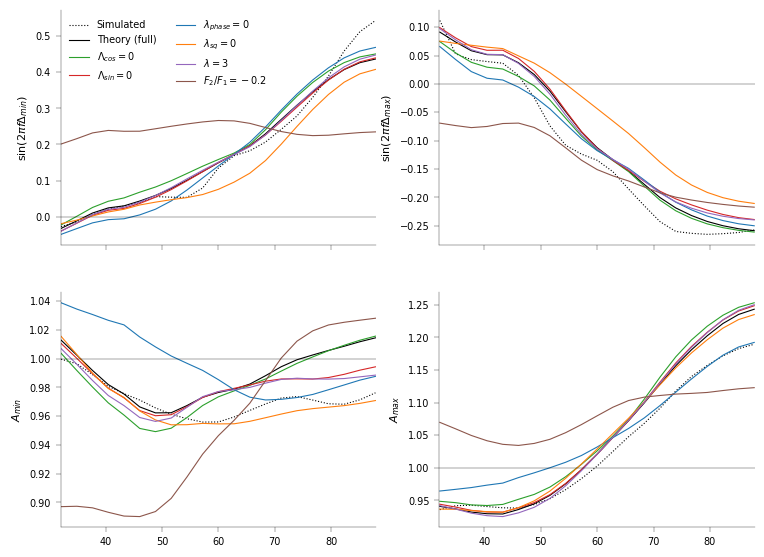

In [186]:
key = 'square_phase_fourier'
plot_approx='theory_full'
plot_const_val = {'$\lambda$': 3, '$F_2/F_1$': -0.2}
y_extrema_param0 = {key2: np.zeros((n_lat, 2)) for key2 in labels_param}
temp_amp_scale_param0 = {key2: np.zeros((n_lat, 2)) for key2 in y_extrema_param0}
for i in range(n_lat):
    for j in range(2):
        for key2 in y_extrema_param0:
            y_extrema_param0[key2][i, j], temp_amp_scale_param0[key2][i, j] = \
                get_extrema_time(ds.time.to_numpy(), sw_amp_coefs['2_harmonic'][i, 1],
                                 plot_const_val[key2] * sw_amp_coefs['2_harmonic'][i, 1] if 'F_2' in key2 else sw_amp_coefs['2_harmonic'][i, 2],
                                 heat_capacity,
                                 plot_const_val[key2] if key2=='$\lambda$' else gamma_params[key][i, 4],
                                 lambda_phase=0 if 'phase' in key2 else gamma_params[key][i, 2],
                                 lambda_sq=0 if 'sq' in key2 else gamma_params[key][i, 3],
                                 lambda_cos=0 if 'cos' in key2 else gamma_params[key][i, 0],
                                 lambda_sin=0 if 'sin' in key2 else gamma_params[key][i, 1],
                                 approx=False if plot_approx=='theory_full' else plot_approx, harmonic_extrema_ind=j+1)[2:]


fig, ax = plt.subplots(2, 2, figsize=(im_sz*2*width['one_col'], 2*im_sz*width['one_col']/ar), sharex=True, sharey=False)
for i in range(2):
    ax[0, i].plot(ds.lat, y_extrema[key]['simulated'][:, i], color='k', linestyle=':', label='Simulated')
    ax[1, i].plot(ds.lat, amp_scale_extrema[key]['simulated'][:, i], color='k', linestyle=':')
    ax[0, i].plot(ds.lat, y_extrema[key][plot_approx][:, i], color='k', label=f'Theory ({plot_approx.replace("theory_", "")})')
    ax[1, i].plot(ds.lat, amp_scale_extrema[key][plot_approx][:, i], color='k')
    for j, key2 in enumerate(labels_param):
        ax[0, i].plot(ds.lat, y_extrema_param0[key2][:, i], color=color_param[j],
                      label=labels_param[j]+f'$={0 if key2 not in plot_const_val else plot_const_val[key2]}$')
        ax[1, i].plot(ds.lat, temp_amp_scale_param0[key2][:, i], color=color_param[j])
ax[0, 0].set_xlim(ax_lims_lat)
ax[0, 0].legend(ncol=2)
ax[0, 0].axhline(0, color='k', lw=ax_linewidth)
ax[0, 1].axhline(0, color='k', lw=ax_linewidth)
ax[1, 0].axhline(1, color='k', lw=ax_linewidth)
ax[1, 1].axhline(1, color='k', lw=ax_linewidth)
ax[0, 0].set_ylabel('$\sin(2\pi f \Delta_{min})$')
ax[0, 1].set_ylabel('$\sin(2\pi f \Delta_{max})$')
ax[1, 0].set_ylabel('$A_{min}$')
ax[1, 1].set_ylabel('$A_{max}$')
plt.show()

In [172]:
# TODO: plot direct Fourier fit extrema
# TODO: plot how extrema vary with parameters in 2D grids